# ResNet

- 加多层不一定能够保障精度的改善（存在模型偏差）
    - 要求复杂模型包含简单模型

## 残差块

- 串联层之后，通过加法使其包含之前的简单模型
    - g(x) [更复杂的模型] = f(x) [新串联的] + x [原有的小模型]
- 来源是VGG
- x的连接可以在不同的层
    
**实现**

- input : x
- F(x):
    - 3x3 Conv
    - BatchNorm
    - ReLU
    - 3x3 Conv
    - BatchNorm
- G(x) = F(x) + 1x1 Conv x (保证通道数一致)
    - ReLU

**架构**：

- 高宽减半的ResNet块（Stride=2）
- 接一堆高宽不变的ResNet块（Stride=1）

**使得更深的模型更容易训练，甚至100层**

**对之后的网络产生了深远的影响**

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import torchvision
import os
import time
from matplotlib import pyplot as plt
from matplotlib_inline import backend_inline

In [2]:
""" 残差块 """
class Residual(torch.nn.Module):
    def __init__(self, input_channels, num_channels, use_1x1_conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1)
        if use_1x1_conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels, kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
        self.relu = nn.ReLU()
        
    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)
    
def resnet_block(input_channels, num_channels, num_residuals, is_first=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not is_first:
            blk.append(Residual(input_channels, num_channels, use_1x1_conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

In [3]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b2 = nn.Sequential(*resnet_block(64, 64, 2, is_first=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

net = nn.Sequential(
    b1, b2, b3, b4, b5,
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(512, 10)
)

In [4]:
X = torch.rand(size=(1, 1, 224, 224), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(f"{layer.__class__.__name__} : {X.shape}")

Sequential : torch.Size([1, 64, 56, 56])
Sequential : torch.Size([1, 64, 56, 56])
Sequential : torch.Size([1, 128, 28, 28])
Sequential : torch.Size([1, 256, 14, 14])
Sequential : torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d : torch.Size([1, 512, 1, 1])
Flatten : torch.Size([1, 512])
Linear : torch.Size([1, 10])


/usr/local/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [5]:
resize = 224
batch_size=256
num_cpu_cores = os.cpu_count()
trans = [torchvision.transforms.ToTensor()]
if resize is not None:
    trans.insert(0, torchvision.transforms.Resize(resize))
trans = torchvision.transforms.Compose(trans)
train_iter = torch.utils.data.DataLoader(torchvision.datasets.FashionMNIST(root="./data", train=True, download=True, transform=trans), batch_size, shuffle=True, num_workers=num_cpu_cores)
test_iter = torch.utils.data.DataLoader(torchvision.datasets.FashionMNIST(root="./data", train=False, download=True, transform=trans), batch_size, shuffle=True, num_workers=num_cpu_cores)

/usr/local/miniconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
""" 累加器对象 """
class Accumulator: # 累加器对象
    """ 在 n 个变量上累加 """
    def __init__(self, n):
        self.data = [0.0] * n # python 语法 [0]*n将n个list连接在一起

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
        # zip() 将迭代器打包成元组

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, index):
        return self.data[index]

""" 与真实值对比 """
def accuracy(y_hat, y):
    """ 分类问题，统计正确个数 """
    # y_hat 是二维矩阵，取每一行的最大值
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1) # 返回最大值对应的序号
    cmp = y_hat.type(y.dtype) == y   # 保证 y 和 y_hat 类型相同
    # cmp 是 bool 类型
    return float(cmp.type(y.dtype).sum())

def evaluate_accuracy_gpu(net, data_iter):
    """使用GPU计算模型在数据集上的精度"""
    device = try_gpu() 
    if isinstance(net, torch.nn.Module):
        net.eval()
    metric = Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

def try_gpu(i = 0):
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f"cuda:{i}")
    else:
        return torch.device('cpu')
    

def train_gpu(net, train_iter, test_iter, num_epochs, lr):
    device = try_gpu()
    print(f'training on {device}')

    def init_weight(m):
        if type(m) == torch.nn.Linear or type(m) == torch.nn.Conv2d:
            torch.nn.init.xavier_uniform_(m.weight)
    net.apply(init_weight)

    net.to(device)
    optimizer = torch.optim.SGD(params=net.parameters(), lr=lr)
    loss = torch.nn.CrossEntropyLoss()
    
    train_l, train_acc, test_acc, time_l = [], [], [], []

    for epoch in range(num_epochs):
        metric = Accumulator(3)
        net.train()
        start = time.perf_counter()
        for i, (X, y) in enumerate(train_iter):
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], accuracy(y_hat=y_hat, y=y), X.shape[0])
        end = time.perf_counter()
        train_l.append(metric[0] / metric[2])
        train_acc.append(metric[1] / metric[2])
        test_acc.append(evaluate_accuracy_gpu(net, test_iter))
        time_l.append(end-start)
        print(f"Epoch {epoch+1}, Using Time : {time_l[-1]:.3f}, train_acc : {train_acc[-1]:.4f} test_acc : {test_acc[-1]:.4f}")
    """绘图"""
    backend_inline.set_matplotlib_formats("svg")
    plt.rcParams['figure.figsize']=(7, 5)
    plt.plot(list(range(num_epochs)), train_l, 'm--')
    plt.plot(list(range(num_epochs)), train_acc, 'r:')
    plt.plot(list(range(num_epochs)), test_acc, 'g-')

    plt.legend(["train_loss", "train_accuracy", "test_accuracy"])
    plt.xlabel('epochs')
    plt.ylabel('percent')
    plt.title(f'{num_epochs} epochs')
    plt.grid(True)

    print(f"Test accuracy : {test_acc[-1]:.3f}")
    print(f'{metric[2] * num_epochs / sum(time_l):.1f} examples/sec on {str(torch.cuda.get_device_name())}')

training on cuda:0
Epoch 1, Using Time : 162.549, train_acc : 0.7963 test_acc : 0.8406
Epoch 2, Using Time : 165.044, train_acc : 0.8933 test_acc : 0.8783
Epoch 3, Using Time : 165.791, train_acc : 0.9166 test_acc : 0.8963
Epoch 4, Using Time : 166.247, train_acc : 0.9324 test_acc : 0.8785
Epoch 5, Using Time : 166.048, train_acc : 0.9460 test_acc : 0.7083
Test accuracy : 0.708
363.3 examples/sec on Tesla T4
Total Time : 876.199176


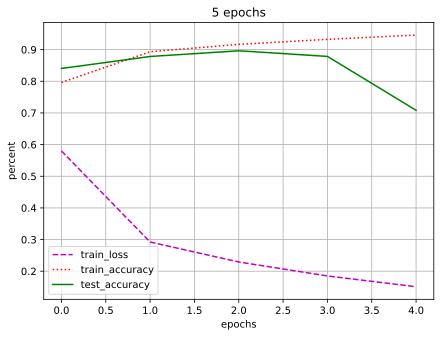

In [7]:
lr, num_epochs = 0.05, 5
start = time.perf_counter()
train_gpu(net, train_iter, test_iter, num_epochs, lr)
end = time.perf_counter()
print(f"Total Time : {end-start:3f}")

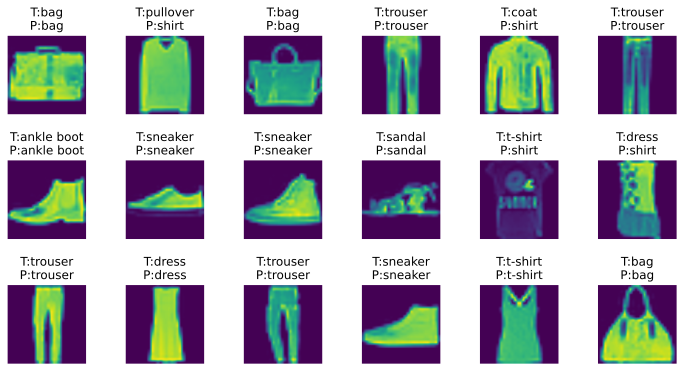

In [8]:
""" 获得标签索引对应文本"""
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat', \
                 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

""" 打印图片 """
def show_img(imgs, num_rows, num_cols, title=None, scale=1.5):
    figsize = (num_cols * scale, num_rows * scale)
    plt.rcParams["figure.figsize"] = figsize
    for i in range(num_rows * num_cols):
        plt.subplot(num_rows, num_cols, i+1)
        plt.title(title[i])
        plt.axis('off')
        if torch.is_tensor(imgs[i].numpy()):
            plt.imshow(imgs[i].numpy())
        else:
            plt.imshow(imgs[i])

def predtic_ch3(net, test_iter, rows, cols):
    n = rows * cols
    for X, y in test_iter:
        break
    X = X.to(try_gpu())
    trues = get_fashion_mnist_labels(y)
    predicts = get_fashion_mnist_labels(net(X).argmax(axis=1))
    title = [f"T:{true}\nP:{predict}" for true, predict in zip(trues, predicts)]
    X = X.to(torch.device('cpu'))
    show_img(X[0:n].reshape([n, 224, 224]), rows, cols, title=title[0:n], scale=2)
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    
predtic_ch3(net, test_iter, 3, 6)

In [9]:
torch.cuda.empty_cache()

# QA

- batch_size 过大会导致样本多样性丢失？收敛变慢
- f(x) = g(x) + x 训练中，如果g(x)不行，就拿不到权重，防止模型变坏
- 使用cos学习率并且简单
- 数据存在误差，还存在 Hard Case

# 梯度更新：

$$\begin{cases}\text{梯度更新}\quad w=w-\eta\frac{\partial y}{\partial w} \\
\text{小网络}\quad y=f(x) \quad \text{梯度}\quad\frac{\partial y}{\partial w} \\
\text{复杂网络}\quad y'=g(f(x)) \quad \text{梯度}\quad\frac{\partial g(y)}{\partial y}\frac{\partial y)}{\partial w}\qquad\frac{\partial g(y)}{\partial y}\text{收敛快，值小}\\
\text{ResNet}\quad y'=g(f(x)) + f(x) \quad \text{梯度}\quad\frac{\partial g(y)}{\partial y}\frac{\partial y)}{\partial w}+\frac{\partial y}{\partial w}\qquad\frac{\partial g(y)}{\partial y}\text{收敛快，值小，但是加法，导数值不受影响}\end{cases}$$